In [1]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox
import pertpy 

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [2]:
%%R
library(edgeR)

Loading required package: limma


# Running on XX cell types

In [3]:
adata_pb = sc.read('./pb_adata_CUPR_sep.h5ad')
adata_pb

AnnData object with n_obs × n_vars = 104 × 16589
    obs: 'publication', 'label', 'cell_type', 'replicate_cat', 'sample', 'sample_rep', 'batch', 'lib_size', 'log_lib_size', 'replicate'
    uns: 'cell_type_colors', 'label_colors', 'log1p', 'pca', 'publication_colors', 'replicate_cat_colors', 'sample_colors', 'sample_rep_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [4]:
# Extract the data as a pandas DataFrame
df = adata_pb.obs[['cell_type', 'label']]

# Create a summary table
summary_table = df.groupby(['cell_type', 'label']).size().unstack(fill_value=0)
summary_table

label,ctrl,stim
cell_type,,
COPs,0,2
MFOLs,4,6
MOL_A,5,8
MOL_B,5,8
MOL_C,5,9
MOL_D,5,4
MOL_E,3,7
MOL_F,3,6
MOL_G,4,7


In [5]:
adata_sub= adata_pb[np.in1d(adata_pb.obs['cell_type'], 
                           ['MOL_B', 'MOL_E'])].copy()

print("Dimensions of adata_sub:", adata_sub.shape)

Dimensions of adata_sub: (23, 16589)


In [6]:
pub_map = {
    '(this study)': 'Adams',
    'Shen et al. 2021': 'Shen'
}

# Update the 'treatment_meta' column based on the mapping
adata_sub.obs['batch'] = adata_sub.obs['publication'].map(pub_map)

In [7]:
# Concatenate 'individual_lesion_condition' and 'replicate' to create 'sample'
adata_sub.obs['cell_type_sample'] = adata_sub.obs['cell_type'].astype(str) + '_' + adata_sub.obs['sample_rep'].astype(str)

In [8]:
adata_sub.obs[:5]

,publication,label,cell_type,replicate_cat,sample,sample_rep,batch,lib_size,log_lib_size,replicate,cell_type_sample
donor_ctrl_1_0-1-0-0-0-0-0,(this study),ctrl,MOL_B,1,ctrl_1,Cupr_ctrl_Adams_1,Adams,294634,12.593489,1,MOL_B_Cupr_ctrl_Adams_1
donor_ctrl_2_0-1-0-0-0-0-0,(this study),ctrl,MOL_B,2,ctrl_2,Cupr_ctrl_Adams_2,Adams,102262,11.535293,2,MOL_B_Cupr_ctrl_Adams_2
donor_ctrl_3_0-1-0-0-0-0-0,Shen et al. 2021,ctrl,MOL_B,3,ctrl_3,Cupr_ctrl_Shen_2,Shen,3475471,15.061241,3,MOL_B_Cupr_ctrl_Shen_2
donor_ctrl_4_0-1-0-0-0-0-0,Shen et al. 2021,ctrl,MOL_B,4,ctrl_4,Cupr_ctrl_Shen_1,Shen,5487794,15.518037,4,MOL_B_Cupr_ctrl_Shen_1
donor_ctrl_5_0-1-0-0-0-0-0,Shen et al. 2021,ctrl,MOL_B,5,ctrl_5,Cupr_ctrl_Shen_3,Shen,4794831,15.383049,5,MOL_B_Cupr_ctrl_Shen_3


# Subset for demyelination and remyelination MOL2 data

In [9]:
# Unique values in the 'condition' column
unique_conditions = adata_sub.obs['cell_type_sample'].unique()
for condition in unique_conditions:
    print(condition)

MOL_B_Cupr_ctrl_Adams_1
MOL_B_Cupr_ctrl_Adams_2
MOL_B_Cupr_ctrl_Shen_2
MOL_B_Cupr_ctrl_Shen_1
MOL_B_Cupr_ctrl_Shen_3
MOL_B_Cupr_5w_2
MOL_B_Cupr_4+3w_1
MOL_B_Cupr_4w_3
MOL_B_Cupr_4w_2
MOL_B_Cupr_4+3w_3
MOL_B_Cupr_4w_4
MOL_B_Cupr_4+3w_2
MOL_B_Cupr_4w_1
MOL_E_Cupr_ctrl_Adams_1
MOL_E_Cupr_ctrl_Shen_2
MOL_E_Cupr_ctrl_Shen_1
MOL_E_Cupr_5w_2
MOL_E_Cupr_4+3w_1
MOL_E_Cupr_4w_3
MOL_E_Cupr_4w_2
MOL_E_Cupr_4+3w_3
MOL_E_Cupr_4w_4
MOL_E_Cupr_4+3w_2


In [10]:
adata_sub= adata_sub[np.in1d(adata_sub.obs['cell_type_sample'], 
                           [
                            'MOL_B_Cupr_ctrl_Shen_2',
                            'MOL_B_Cupr_ctrl_Shen_1',
                            'MOL_B_Cupr_ctrl_Shen_3',
                            'MOL_E_Cupr_4+3w_3',
                            'MOL_E_Cupr_4+3w_2',
                            'MOL_E_Cupr_4+3w_1'
                            #'MOL_trt_Cupr_4+3w_2',
                           ])].copy()

print("Dimensions of adata_sub:", adata_sub.shape)

Dimensions of adata_sub: (6, 16589)


In [11]:
# Check if the 'sample_rep' column exists
if 'sample_rep' in adata_sub.obs.columns:
    # Set the 'sample_rep' column as the index
    adata_sub.obs.set_index('sample_rep', inplace=True)
else:
    print("The column 'sample_rep' does not exist in adata_sub.obs.")

adata_sub.obs.index.name = None

In [12]:
adata_sub.obs

,publication,label,cell_type,replicate_cat,sample,batch,lib_size,log_lib_size,replicate,cell_type_sample
Cupr_ctrl_Shen_2,Shen et al. 2021,ctrl,MOL_B,3,ctrl_3,Shen,3475471,15.061241,3,MOL_B_Cupr_ctrl_Shen_2
Cupr_ctrl_Shen_1,Shen et al. 2021,ctrl,MOL_B,4,ctrl_4,Shen,5487794,15.518037,4,MOL_B_Cupr_ctrl_Shen_1
Cupr_ctrl_Shen_3,Shen et al. 2021,ctrl,MOL_B,5,ctrl_5,Shen,4794831,15.383049,5,MOL_B_Cupr_ctrl_Shen_3
Cupr_4+3w_1,Shen et al. 2021,stim,MOL_E,3,stim_3,Shen,38819,10.566665,3,MOL_E_Cupr_4+3w_1
Cupr_4+3w_3,Shen et al. 2021,stim,MOL_E,6,stim_6,Shen,426541,12.963464,6,MOL_E_Cupr_4+3w_3
Cupr_4+3w_2,Shen et al. 2021,stim,MOL_E,8,stim_8,Shen,395147,12.887013,8,MOL_E_Cupr_4+3w_2


# Rename the MOL clusters for NEW letter based nomenclature

In [13]:
#Check the counts data
print(adata_sub.X[:5, :5])

[[  1 172   6  65  93]
 [  0 272   7  85 163]
 [  2 279   3 124  73]
 [  0   5   0   0   6]
 [  0  29   0   1  11]]


# Start R code: QC of log transformation

In [14]:
%%R -i adata_sub

# Concatenate label and cell type for group factor
group <- colData(adata_sub)$label #ctrl or stim
replicate <- colData(adata_sub)$replicate #replicate number
batch <- colData(adata_sub)$batch

treatments <- data.frame("Group"=group, "Reps"=replicate, "Batch"= batch)
print(treatments)

                 Group Reps Batch
Cupr_ctrl_Shen_2  ctrl    3  Shen
Cupr_ctrl_Shen_1  ctrl    4  Shen
Cupr_ctrl_Shen_3  ctrl    5  Shen
Cupr_4+3w_1       stim    3  Shen
Cupr_4+3w_3       stim    6  Shen
Cupr_4+3w_2       stim    8  Shen


In [15]:
%%R

#Create a DGElist object using the anndata counts in 'X'
x <- DGEList(assay(adata_sub, "X"), group=colData(adata_sub)$label)

samplenames <- colnames(x$counts)

print("Dimensions before subsetting:")
print(dim(x))

# Check counts per group before filtering
print(table(x$samples$group))

[1] "Dimensions before subsetting:"
[1] 16589     6

ctrl stim 
   3    3 


In [16]:
%%R

cd <- x$samples$group
print(cd)

[1] ctrl ctrl ctrl stim stim stim
Levels: ctrl stim


In [17]:
%%R

# Adjust for batch-- ie publication in the model matrix
design <- model.matrix(~0 + cd)
design

  cdctrl cdstim
1      1      0
2      1      0
3      1      0
4      0      1
5      0      1
6      0      1
attr(,"assign")
[1] 1 1
attr(,"contrasts")
attr(,"contrasts")$cd
[1] "contr.treatment"



In [18]:
%%R

# More strict removal of genes, tried group, pub and batch
keep.expr <- filterByExpr(x, design)
x2 <- x[keep.expr,, keep.lib.sizes=FALSE]
dim(x2)

[1] 9013    6


In [19]:
%%R

## OLD DON"T USE THIS

keep.exprs <- filterByExpr(x, group=batch)
b <- x[keep.exprs,, keep.lib.sizes=FALSE]
dim(b)

[1] 4890    6


In [20]:
%%R
#X is before trimming, Y is after trimming
L <- mean(x2$samples$lib.size) * 1e-6
M <- median(x2$samples$lib.size) * 1e-6
c(L, M)

[1] 2.413261 1.930503


In [21]:
%%R
## Calc norm factors before to normalize library sizes, then cpm divides counts by lib sizes
#X is before trimming, Y is after trimming, X2 is also trimmed but differently
x2 <- calcNormFactors(x2, method = "TMM")
x2$samples$norm.factors

[1] 0.9923497 0.9661037 0.9244892 1.3410176 0.9355995 0.8992598


In [22]:
%%R
#X2 is the norm lib sizes and trimmed
cpm <- edgeR::cpm(x2, log=FALSE, prior.counts=3)
lcpm <- edgeR::cpm(x2, log=TRUE, prior.count=3)

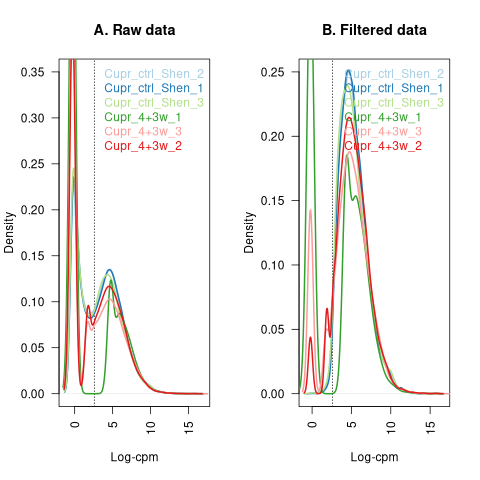

In [23]:
%%R
lcpm.cutoff <- log2(10/M + 2/L)
library(RColorBrewer)
nsamples <- ncol(x2)
col <- brewer.pal(nsamples, "Paired")

par(mfrow=c(1,2))

lcpm <- edgeR::cpm(x, log=TRUE)
plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.35), las=2, main="", xlab="")
title(main="A. Raw data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)
for (i in 2:nsamples){
  den <- density(lcpm[,i])
  lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", samplenames, text.col=col, bty="n")

lcpm <- edgeR::cpm(x2, log=TRUE)
plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.25), las=2, main="", xlab="")
title(main="B. Filtered data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)
for (i in 2:nsamples){
  den <- density(lcpm[,i])
  lines(den$x, den$y, col=col[i], lwd=2)
}
legend("topright", samplenames, text.col=col, bty="n")

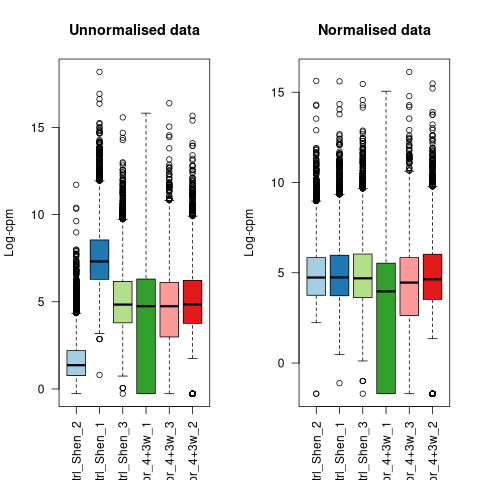

In [24]:
%%R
y2 <- x2
y2$samples$norm.factors <- 1
y2$counts[,1] <- ceiling(y2$counts[,1]*0.05)
y2$counts[,2] <- y2$counts[,2]*5

par(mfrow=c(1,2))
lcpm <- edgeR::cpm(y2, log=TRUE)
boxplot(lcpm, las=2, col=col, main="")
title(main="Unnormalised data", ylab="Log-cpm")

y3 <- calcNormFactors(y2)
y3$samples$norm.factors

lcpm <- edgeR::cpm(y3, log=TRUE)
boxplot(lcpm, las=2, col=col, main="")
title(main="Normalised data", ylab="Log-cpm")

# Show how log transf + batch removal affects the separation of samples:

In [25]:
%%R
cd <- x2$samples$group
print(cd)

[1] ctrl ctrl ctrl stim stim stim
Levels: ctrl stim


In [26]:
%%R
#Make new count matrix with log counts and DGE data from X2 (trimmed, normfactors)
x3 <- x2
x3$counts <- lcpm

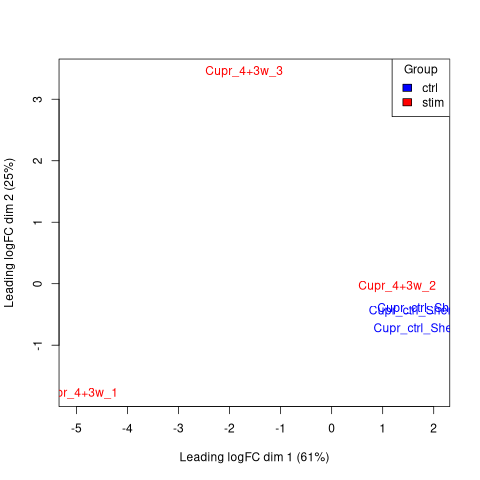

In [27]:
%%R
# Assuming 'group' is stored in y$samples dataframe
group <- x2$samples$group

# Generate a numeric vector from group factors (if not already factor, convert it)
group_factor <- as.factor(group)
group_colors <- as.numeric(group_factor)  # This converts factors to unique integers

# Define a set of colors corresponding to the factors
# Example: If you have two groups, you could define two colors
colors <- c("blue", "red")  # Adjust the number and colors based on your actual groups

# Use these colors in your plotMDS
plotMDS(x2, col = colors[group_colors])

# Adding a legend for clarity
legend("topright", legend=levels(group_factor), fill=colors, title="Group")

In [28]:
%%R
# Adjust for batch-- ie publication in the model matrix
design <- model.matrix(~0 + cd)
design

  cdctrl cdstim
1      1      0
2      1      0
3      1      0
4      0      1
5      0      1
6      0      1
attr(,"assign")
[1] 1 1
attr(,"contrasts")
attr(,"contrasts")$cd
[1] "contr.treatment"



In [29]:
%%R
contr.matrix <- makeContrasts(cdstim - cdctrl, levels = colnames(design))
contr.matrix

        Contrasts
Levels   cdstim - cdctrl
  cdctrl              -1
  cdstim               1


In [30]:
%%R
# Convert to CPM and log2 transformation. 
logCPM <- edgeR::cpm(x2, log=TRUE, prior.count=3)

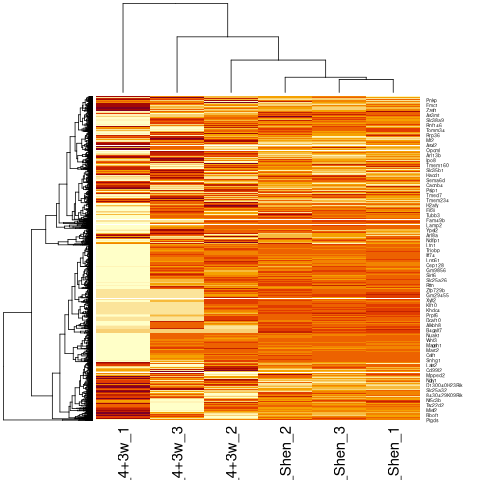

In [31]:
%%R
heatmap(logCPM)

# Lets try with voom:

In [32]:
%%R
# Adjust for batch-- ie publication in the model matrix
design <- model.matrix(~0 + cd)
design

  cdctrl cdstim
1      1      0
2      1      0
3      1      0
4      0      1
5      0      1
6      0      1
attr(,"assign")
[1] 1 1
attr(,"contrasts")
attr(,"contrasts")$cd
[1] "contr.treatment"



In [33]:
%%R
contr.matrix <- makeContrasts(cdstim - cdctrl, levels = colnames(design))
contr.matrix

        Contrasts
Levels   cdstim - cdctrl
  cdctrl              -1
  cdstim               1


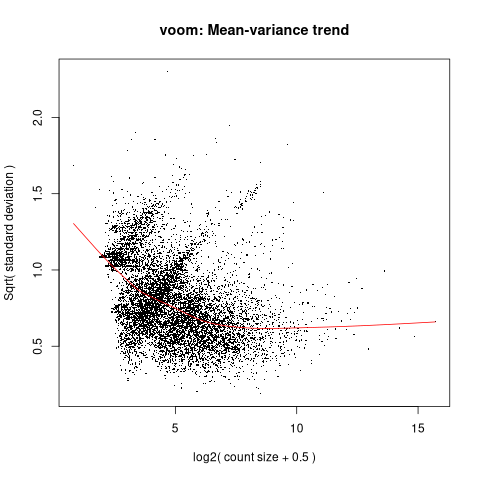

In [34]:
%%R
y <- voom(x2$counts, design, plot=TRUE, lib.size=colSums(x2$counts)*x2$samples$norm.factors)

In [35]:
%%R
fit <- lmFit(y, design)
head(coef(fit))

                cdctrl   cdstim
0610009B22Rik 5.783775 6.052608
0610009L18Rik 4.368270 2.394322
0610010F05Rik 4.601137 4.845469
0610010K14Rik 6.601511 6.532694
0610012G03Rik 6.712453 6.695621
0610030E20Rik 4.627528 4.182927


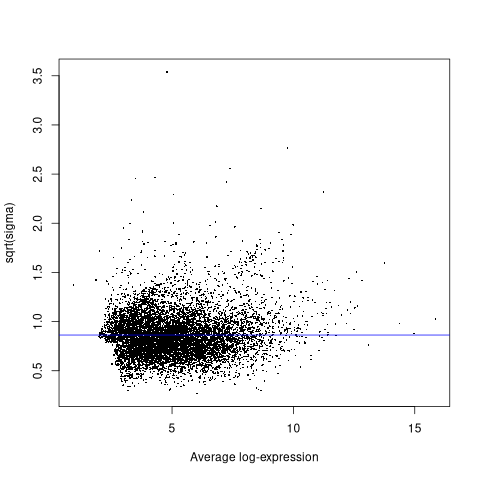

In [36]:
%%R
contr <- makeContrasts(cdstim - cdctrl, levels = colnames(coef(fit)))
tmp <- contrasts.fit(fit, contr)
tmp2 <- eBayes(tmp)

plotSA(tmp2, xlab = "Average log-expression", ylab = "sqrt(sigma)", zero.weights = FALSE,
       pch = 16, cex = 0.3, col = c("black","red"))

In [37]:
%%R
# Retrieve the top results without sorting by p-value directly
tt <- topTable(tmp2, sort.by = "P", n = Inf)
head(tt, 10)

             logFC  AveExpr         t      P.Value    adj.P.Val         B
C4b       6.137261 5.818624 18.285776 2.682680e-09 2.417899e-05 10.579028
Piezo2    6.241072 3.705541 14.660212 2.515039e-08 1.133402e-04  7.479602
Slc9a3r2  3.683479 6.796896 13.700845 4.953234e-08 1.488117e-04  8.829377
Serpina3n 9.137080 3.790188 13.244481 6.942416e-08 1.564300e-04  5.655664
Masp1     4.671261 4.733943 11.645497 2.474111e-07 4.459833e-04  6.964332
Rab3b     3.655440 4.095090  9.982830 1.101098e-06 1.654033e-03  5.534826
Col23a1   5.038178 3.322188  9.726485 1.411673e-06 1.817629e-03  4.908165
Srd5a1    2.361319 6.226401  8.957402 3.075691e-06 3.465150e-03  5.051774
Tma16     2.343679 6.806274  8.660291 4.214999e-06 3.842006e-03  4.771627
Shisa8    2.630342 5.593980  8.649816 4.262738e-06 3.842006e-03  4.701774


In [38]:
%%R
length(which(tt$adj.P.Val < 0.05))

[1] 29


In [39]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
significant_genes <- tt[tt$adj.P.Val < 0.05 & abs(tt$logFC) > 0.7, ]
num_significant_genes <- nrow(significant_genes)

# Print the number of significant genes
print(num_significant_genes)

[1] 29


In [40]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_up <- tt[tt$adj.P.Val < 0.05 & tt$logFC > 1, ]
num_genes_up <- nrow(genes_up)

# Print the number of significant genes
print(num_genes_up)

genes_up_sorted <- genes_up[order(genes_up$logFC, decreasing = TRUE), ]

# View the head of the significant genes data frame
head(genes_up_sorted)

[1] 25
             logFC  AveExpr         t      P.Value    adj.P.Val         B
Serpina3n 9.137080 3.790188 13.244481 6.942416e-08 1.564300e-04  5.655664
Piezo2    6.241072 3.705541 14.660212 2.515039e-08 1.133402e-04  7.479602
C4b       6.137261 5.818624 18.285776 2.682680e-09 2.417899e-05 10.579028
Col23a1   5.038178 3.322188  9.726485 1.411673e-06 1.817629e-03  4.908165
Masp1     4.671261 4.733943 11.645497 2.474111e-07 4.459833e-04  6.964332
Klk6      4.603915 4.742543  8.029653 8.466806e-06 5.843332e-03  4.002461


In [41]:
%%R
if ('Gfap' %in% rownames(genes_up_sorted)) {
    print("Gene is in the index of genes_up_sorted")
} else {
    print("Gene is not in the index of genes_up_sorted")
}

[1] "Gene is in the index of genes_up_sorted"


In [42]:
%%R
if ('Klk8' %in% rownames(genes_up_sorted)) {
    print("Gene is in the index of genes_up_sorted")
} else {
    print("Gene is not in the index of genes_up_sorted")
}

[1] "Gene is not in the index of genes_up_sorted"


In [43]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_down <- tt[tt$adj.P.Val < 0.05 & tt$logFC < -1, ]
num_genes_down <- nrow(genes_down)

# Print the number of significant genes
print(num_genes_down)

genes_down_sorted <- genes_down[order(genes_down$logFC, decreasing = FALSE), ]

# View the head of the significant genes data frame
head(genes_down_sorted)

[1] 4
                  logFC  AveExpr         t      P.Value   adj.P.Val        B
Spock3        -4.083412 6.525730 -7.968739 9.076517e-06 0.005843332 3.817484
Rbm3          -3.505643 6.029755 -7.693018 1.249632e-05 0.007039334 3.320795
9330111N05Rik -2.940850 5.472197 -5.756363 1.525235e-04 0.047403261 1.234116
Ndrg2         -2.495739 5.805704 -5.785455 1.463667e-04 0.047403261 1.306164


# If output --> change name!

In [ ]:
%%R
# Add row names as a new column
tt$gene <- rownames(tt)

# Optionally reorder or select columns
tt <- tt[, c("gene", names(tt)[1:6])]

# Write to CSV file
write.table(tt, file = "./files/Cupr_remyel_MOL_BvE_voom_NEW.csv", 
            row.names = FALSE, sep = ",", quote = FALSE)

# Try voom wqw 

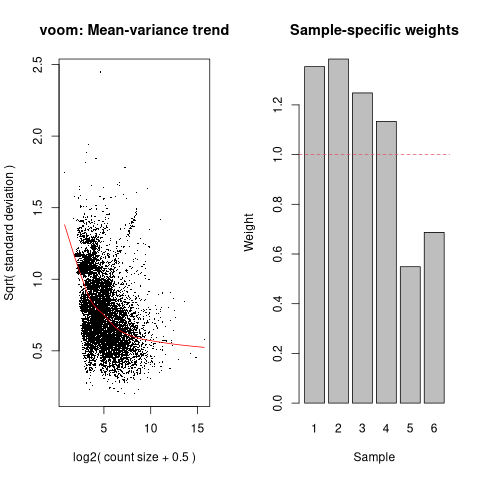

In [44]:
%%R

y_vqw_full <- voomWithQualityWeights(x2$counts, design, plot=TRUE)

In [45]:
%%R

fit <- lmFit(y_vqw_full, design)

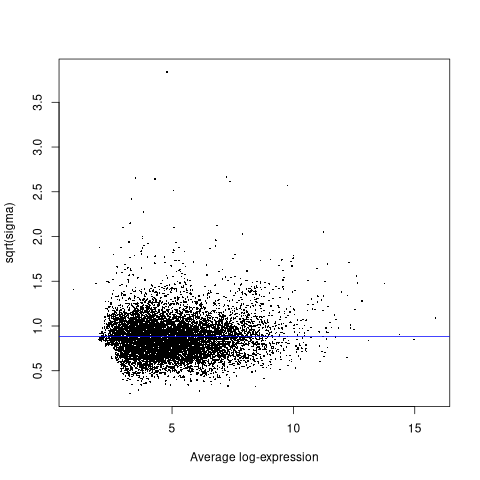

In [46]:
%%R

tmp <- contrasts.fit(fit, contr)
tmp2 <- eBayes(tmp)
tt_full <- topTable(tmp2, sort.by = "P", n = Inf)

plotSA(tmp2, xlab = "Average log-expression", ylab = "sqrt(sigma)", zero.weights = FALSE,
       pch = 16, cex = 0.3, col = c("black","red"))

In [47]:
%%R

# Retrieve the top results without sorting by p-value directly
tt <- topTable(tmp2, sort.by = "P", n = Inf)
head(tt, 10)

             logFC  AveExpr         t      P.Value    adj.P.Val         B
C4b       6.151585 5.818622 19.992477 1.829276e-10 1.648726e-06 12.354263
Serpina3n 9.161969 3.790186 14.696618 6.051824e-09 2.264151e-05  6.628610
Slc9a3r2  3.657372 6.796894 14.412089 7.536286e-09 2.264151e-05 10.233557
Piezo2    6.243185 3.705540 13.482177 1.587673e-08 3.577424e-05  7.746953
Masp1     4.699260 4.733942 11.773052 7.089986e-08 1.278041e-04  7.671355
Col23a1   5.072988 3.322187  9.577084 6.530516e-07 9.809924e-04  5.287208
Klk6      4.744174 4.742541  8.993505 1.261952e-06 1.624854e-03  5.528016
Rab3b     3.656671 4.095089  8.814232 1.555255e-06 1.752189e-03  5.030166
Tma16     2.323287 6.806272  8.463310 2.363577e-06 2.337598e-03  5.205041
Marcksl1  1.882014 8.330468  8.386879 2.593584e-06 2.337598e-03  5.170486


In [48]:
%%R
length(which(tt$adj.P.Val < 0.05))

[1] 25


In [49]:
%%R

# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_up <- tt[tt$adj.P.Val < 0.05 & tt$logFC > 0.7, ]
num_genes_up <- nrow(genes_up)

# Print the number of significant genes
print(num_genes_up)

genes_up_sorted <- genes_up[order(genes_up$logFC, decreasing = TRUE), ]

# View the head of the significant genes data frame
head(genes_up_sorted)

[1] 23
             logFC  AveExpr         t      P.Value    adj.P.Val         B
Serpina3n 9.161969 3.790186 14.696618 6.051824e-09 2.264151e-05  6.628610
Piezo2    6.243185 3.705540 13.482177 1.587673e-08 3.577424e-05  7.746953
C4b       6.151585 5.818622 19.992477 1.829276e-10 1.648726e-06 12.354263
Col23a1   5.072988 3.322187  9.577084 6.530516e-07 9.809924e-04  5.287208
Klk6      4.744174 4.742541  8.993505 1.261952e-06 1.624854e-03  5.528016
Masp1     4.699260 4.733942 11.773052 7.089986e-08 1.278041e-04  7.671355


In [50]:
%%R

# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_down <- tt[tt$adj.P.Val < 0.05 & tt$logFC < -0.7, ]
num_genes_down <- nrow(genes_down)

# Print the number of significant genes
print(num_genes_down)

genes_down_sorted <- genes_down[order(genes_down$logFC, decreasing = FALSE), ]

# View the head of the significant genes data frame
head(genes_down_sorted)

[1] 2
           logFC  AveExpr         t      P.Value   adj.P.Val        B
Spock3 -4.003635 6.525728 -7.513672 7.845635e-06 0.005892725 3.818885
Rbm3   -3.514421 6.029754 -6.237390 4.674263e-05 0.023405073 1.890555


## Save output

In [51]:
%%R
# Add row names as a new column
tt$gene <- rownames(tt)

# Optionally reorder or select columns
tt <- tt[, c("gene", names(tt)[1:6])]

# Write to CSV file
write.table(tt, file = "./files/Cupr_remyel_MOL_BvE_voom_wqw.csv", 
            row.names = FALSE, sep = ",", quote = FALSE)

# Check LR Pair Overlap

In [ ]:
import liana as li
lr_pairs = li.resource.select_resource('mouseconsensus')
lr_pairs.head()

In [ ]:
DEG_all = pd.read_csv('./files/Cupr_remyel_MOL_BvE_voom_FINAL.csv', index_col=None)
DEG_all.rename(columns={'adj.P.Val': 'Padj'}, inplace=True)
DEG_all.rename(columns={'P.Value': 'Pvalue'}, inplace=True)
DEG_all.shape

In [ ]:
sigs = DEG_all[(DEG_all.Padj < 0.05) & (abs(DEG_all.logFC) >= 1)]
sigs.shape

In [ ]:
# Step 1: Convert ligands and receptors to a list
ligands = lr_pairs['ligand'].tolist()
receptors = lr_pairs['receptor'].tolist()

# Step 2: Filter DEGs from 'sigs'
degs = set(sigs['gene'])  # Create a set for faster lookup

# Step 3: Check which ligand-receptor pairs have both ligands and receptors as DEGs
matched_pairs = lr_pairs[(lr_pairs['ligand'].isin(degs)) & (lr_pairs['receptor'].isin(degs))]

# Step 4: Count the matched pairs
num_matched_pairs = matched_pairs.shape[0]

# Output the result
print(f'Total ligand-receptor pairs where both are differentially expressed: {num_matched_pairs}')

# Step 5: Optional - view the matched pairs with direction of change
matched_pairs_with_logFC = matched_pairs.merge(sigs[['gene', 'logFC']], left_on='ligand', right_on='gene', how='left')\
                                        .merge(sigs[['gene', 'logFC']], left_on='receptor', right_on='gene', how='left', suffixes=('_ligand', '_receptor'))

# Sorting the table by 'logFC_ligand' in descending order
sorted_table = matched_pairs_with_logFC.sort_values(by='logFC_ligand', ascending=False)

# Displaying the sorted table with the selected columns
sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']]

In [ ]:
sigs_up = DEG_all[(DEG_all.Padj < 0.05) & (DEG_all.logFC >= 1)]
sigs_up.shape

In [ ]:
# Step 1: Convert ligands and receptors to a list
ligands = lr_pairs['ligand'].tolist()
receptors = lr_pairs['receptor'].tolist()

# Step 2: Filter DEGs from 'sigs'
degs = set(sigs_up['gene'])  # Create a set for faster lookup

# Step 3: Check which ligand-receptor pairs have both ligands and receptors as DEGs
matched_pairs = lr_pairs[(lr_pairs['ligand'].isin(degs)) & (lr_pairs['receptor'].isin(degs))]

# Step 4: Count the matched pairs
num_matched_pairs = matched_pairs.shape[0]

# Output the result
print(f'Total ligand-receptor pairs where both are differentially expressed: {num_matched_pairs}')

# Step 5: Optional - view the matched pairs with direction of change
matched_pairs_with_logFC = matched_pairs.merge(sigs[['gene', 'logFC']], left_on='ligand', right_on='gene', how='left')\
                                        .merge(sigs[['gene', 'logFC']], left_on='receptor', right_on='gene', how='left', suffixes=('_ligand', '_receptor'))

# Sorting the table by 'logFC_ligand' in descending order
sorted_table = matched_pairs_with_logFC.sort_values(by='logFC_ligand', ascending=False)

# Displaying the sorted table with the selected columns
sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']]

In [ ]:
sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']].to_csv('output_table.tsv', sep='\t', index=False)